# Reliability Study Analysis
### Nicholas Miklaucic
This is some graphs and stuff I made trying to get a feel for the data. I'm sure there are some things I've messed up and misinterpreted but I hope this is helpful, especially as it can corroborate or conflict with your own analysis. If I missed an axis label or two and things aren't clear please let me know.

If you want to run this yourself, you'll need the processed data that I emailed to you last time: `processed_data.xlsx`. Everything is generated from that Excel sheet.

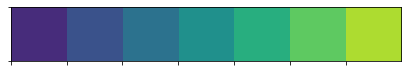

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

USE_DARK = False
palette = cmap = 'viridis'
c0, c1, c2, c3, c4, c5, c6 = sns.color_palette(palette, 7)
sns.palplot(sns.color_palette(palette, 7))

rc = {
    'font.family': 'Source Sans Pro',
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': (12, 7),
    'grid.alpha': 0,
}

if USE_DARK:
    COLORS = {
        'fg': '0.8',
        'fg_muted': '0.7',
        'bg': '0.1',
        'bg_muted': '0.2'
    }
    SNS_STYLE='dark'
else:
    COLORS = {
        'fg': '0.1',
        'fg_muted': '0.2',
        'bg': '0.97',
        'bg_muted': '0.9',
    }
    SNS_STYLE='white'

rc.update({
    'text.color': COLORS['fg'],
    'figure.facecolor': COLORS['bg'],
    'axes.facecolor': COLORS['bg'],
    'axes.edgecolor': COLORS['bg_muted'],
    'axes.labelcolor': COLORS['fg_muted'],
    'xtick.color': COLORS['fg'],
    'ytick.color': COLORS['fg'],
    'legend.edgecolor': COLORS['bg_muted'],
})
    
sns.set(context='notebook', style=SNS_STYLE, palette=palette, rc=rc)

In [2]:
sheets = pd.read_excel("processed_data.xlsx", sheet_name=None)
(data, _beliefs_only, beliefs_change, _unmatched_part1, _unmatched_part2, control_means, 
 intervention_means, part1, _part2_ctrl, _part2_intr) = sheets.values()

In [3]:
questions = ['daddy-long-legs', 'women-talk-more', 'wifi-no-cause-cancer', 'illegal-immigrants-crime-less', 'mozart-boosts-iq', 'sugar-hyperactive', 
            'ostriches-hide-head', 'cancer-alternative-medicine', 'caucasian-blue-eyes', 'sleepwalkers-complex-tasks', 'universal-gestures', 
             'taller-in-morning', 'urine-jellyfish-sting', 'opera-shatter-glass', 'carrots-skin-orange', '90%-communication-nonverbal',
            'yawning-contagious', 'goldfish-short-memory', 'use-10%-of-brain', 'dogs-chocolate-bad', 'laughing-improves-vascular', 
            'alcohol-cooks-off', 'testosterone-helps-memory', 'gender-pay-gap', 'glasses-linked-iq', 'cops-dying-more', 'cockroach-headless',
            'gun-murders-highest', 'redheads-dying-out', 'placenta-side-gender', '80%-ocean-unexplored', 'honey-antibacterial',
            'sharks-no-cancer', 'tsunami-caused-earthquake', 'marmite-meat-based', 'elephants-never-forget', 'achoo', 'hypnosis-pain',
            'saunas-sweat-toxins', 'dogs-smell-cancer', 'humans-regrow-tips', 'mercury-vaccines-harmful']
item_wordings = [col.split(' - ')[0] for col in data.columns if col.endswith("to be true?")]
part1_belief = [col for col in data.columns if col.endswith("to be true?")]
familiarity = [col for col in data.columns if col.endswith("this statement before?")]
importance_you = [col for col in data.columns if col.endswith("you whether this is true or false?")]
importance_society = [col for col in data.columns if col.endswith("society whether this is true or false?")]
part2_belief = [col for col in data.columns if col.endswith("to be true? ")]
surprise = [col for col in part1.columns if "surprised" in col]
truth = np.array(["TRUE" in s for s in surprise])

responses = (part1_belief, familiarity, importance_you, importance_society, part2_belief)

In [4]:
type_names = ("Belief 1", "Familiarity", "Importance (You)", "Importance (Society)", "Belief 2")
ID_COL = 'What is your Prolific ID?'

INTERVENTION = 1
CONTROL = 2

def item_number(col):
    try:
        return item_wordings.index(col.split(' - ')[0])
    except ValueError:
        return -1
    
def question_type(col):
    for i, response_type in enumerate(responses):
        if col in response_type:
            return i
    return -1

item_group = data.melt(id_vars=['Condition', ID_COL], var_name='question', value_name='response')
item_group.rename(columns={'Condition': 'condition'}, inplace=True)
item_group['item'] = item_group['question'].apply(item_number)
item_group['type_'] = item_group['question'].apply(question_type)
item_group = item_group.query('type_ != -1 and item != -1')
item_group.loc[:, 'response'] = pd.to_numeric(item_group['response'])
item_group['type_'] = item_group['type_'].apply(lambda i: type_names[i])
intr = item_group.query('condition == @INTERVENTION')
ctrl = item_group.query('condition == @CONTROL')
items = sorted(set(item_group['item']))

# Sanity Checks

Some data quality checks I thought might be useful.

### Part 1 Belief Homogeneity
Control means and intervention data for part 1 should be very, very similar, because at this point nothing distinguishes the two groups.

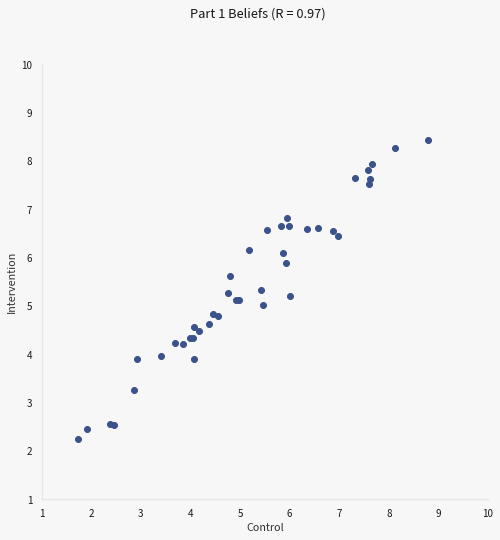

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(control_means['Belief 1'], intervention_means['Belief 1'], color=c1)
ax.set_xlim(1, 10)
ax.set_ylim(1, 10)
ax.set_xlabel("Control")
ax.set_ylabel("Intervention")
fig.suptitle("Part 1 Beliefs (R = {:.2f})".format(scipy.stats.pearsonr(control_means['Belief 1'], intervention_means['Belief 1'])[0]));

That was comparing means to means, but we can also compare the distributions of specific questions.

The Kolmogorov-Smirnov test has test statistic 0.050 and associated p-value 0.866
Student's t-test has test statistic 0.214 and associated p-value 0.831


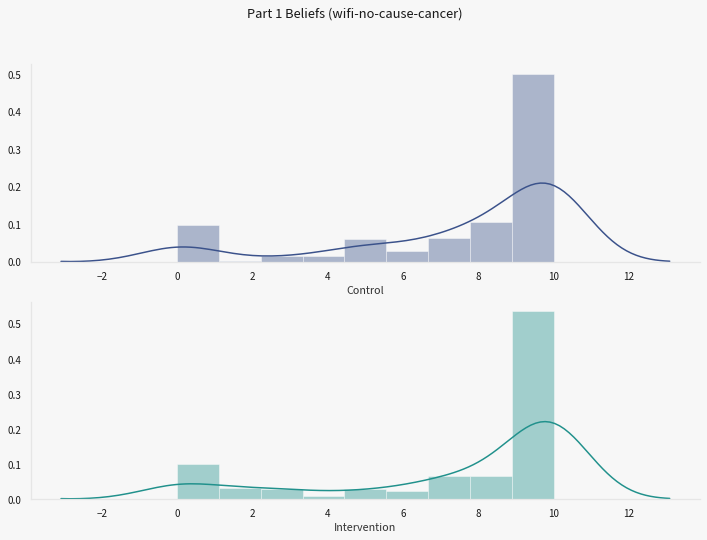

In [6]:
# the index of the question used, starting at 0: we're using the second one, "females talk more than males"
QUESTION = 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
col = part1_belief[QUESTION]
_ctrl = data.query('Condition == @CONTROL')[col]
_intr = data.query('Condition == @INTERVENTION')[col]
sns.distplot(_ctrl, ax=ax1, label='Response', axlabel='Control', color=c1)
sns.distplot(_intr, ax=ax2, label='Response', axlabel='Intervention', color=c3)
fig.suptitle("Part 1 Beliefs ({})".format(questions[QUESTION]))

print("The Kolmogorov-Smirnov test has test statistic {:.3f} and associated p-value {:.3f}".format(*scipy.stats.ks_2samp(_ctrl, _intr)))
print("Student's t-test has test statistic {:.3f} and associated p-value {:.3f}".format(*scipy.stats.ttest_ind(_ctrl, _intr)))

I'm not entirely certain what to make of this: there does appear to be something different between the groups for some questions (you can change the `QUESTION` number in the code to change which question is shown). Perhaps being told that some things are myths somehow primes people to be more or less trustworthy of future questions? The first question isn't different between the two groups. I'm not quite sure.

### Test-Retest Reliability
We can also check, in the control group, that the two different tests are more or less the same.

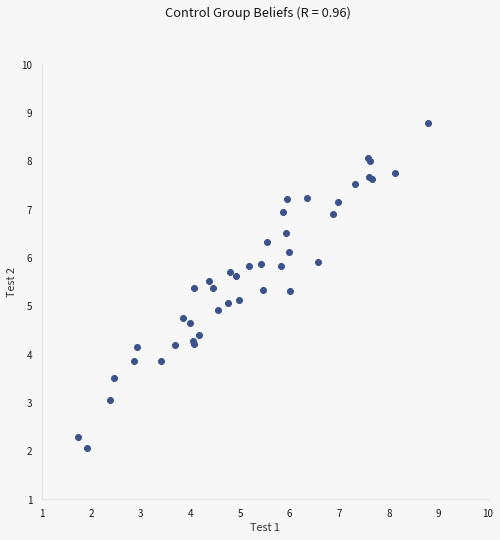

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(control_means['Belief 1'], control_means['Belief 2'], color=c1)
ax.set_xlim(1, 10)
ax.set_ylim(1, 10)
ax.set_xlabel("Test 1")
ax.set_ylabel("Test 2")
fig.suptitle("Control Group Beliefs (R = {:.2f})".format(scipy.stats.pearsonr(control_means['Belief 1'], control_means['Belief 2'])[0]));

Just like last time, we can also look at specific questions. I'm putting them on top of each other, so you should compare columns to see if they're visually similar.

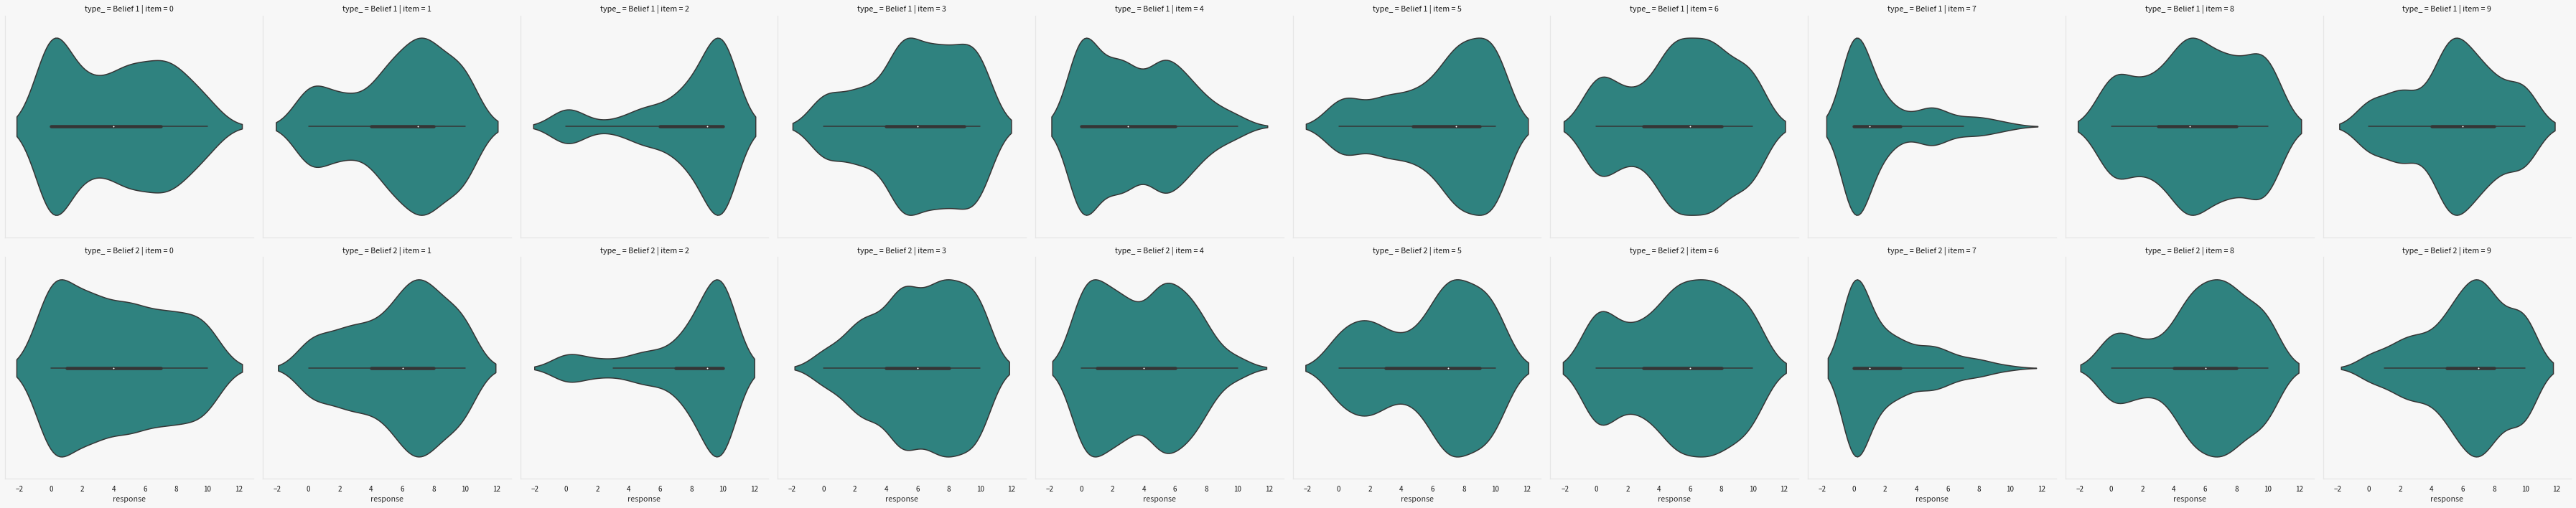

In [8]:
# There are a lot of ITEMS, so only show first 10
ITEMS = range(10)
TYPES = ('Belief 1', 'Belief 2')
sns.catplot(data=item_group.query('condition == @CONTROL and item in @ITEMS and type_ in @TYPES'), col='item', row='type_', 
            x='response', kind='violin', palette=palette+"_r");

Visually, this looks very good: the distributions are very, very similar. I can do another plot, comparing the means with confidence intervals, to show another angle:

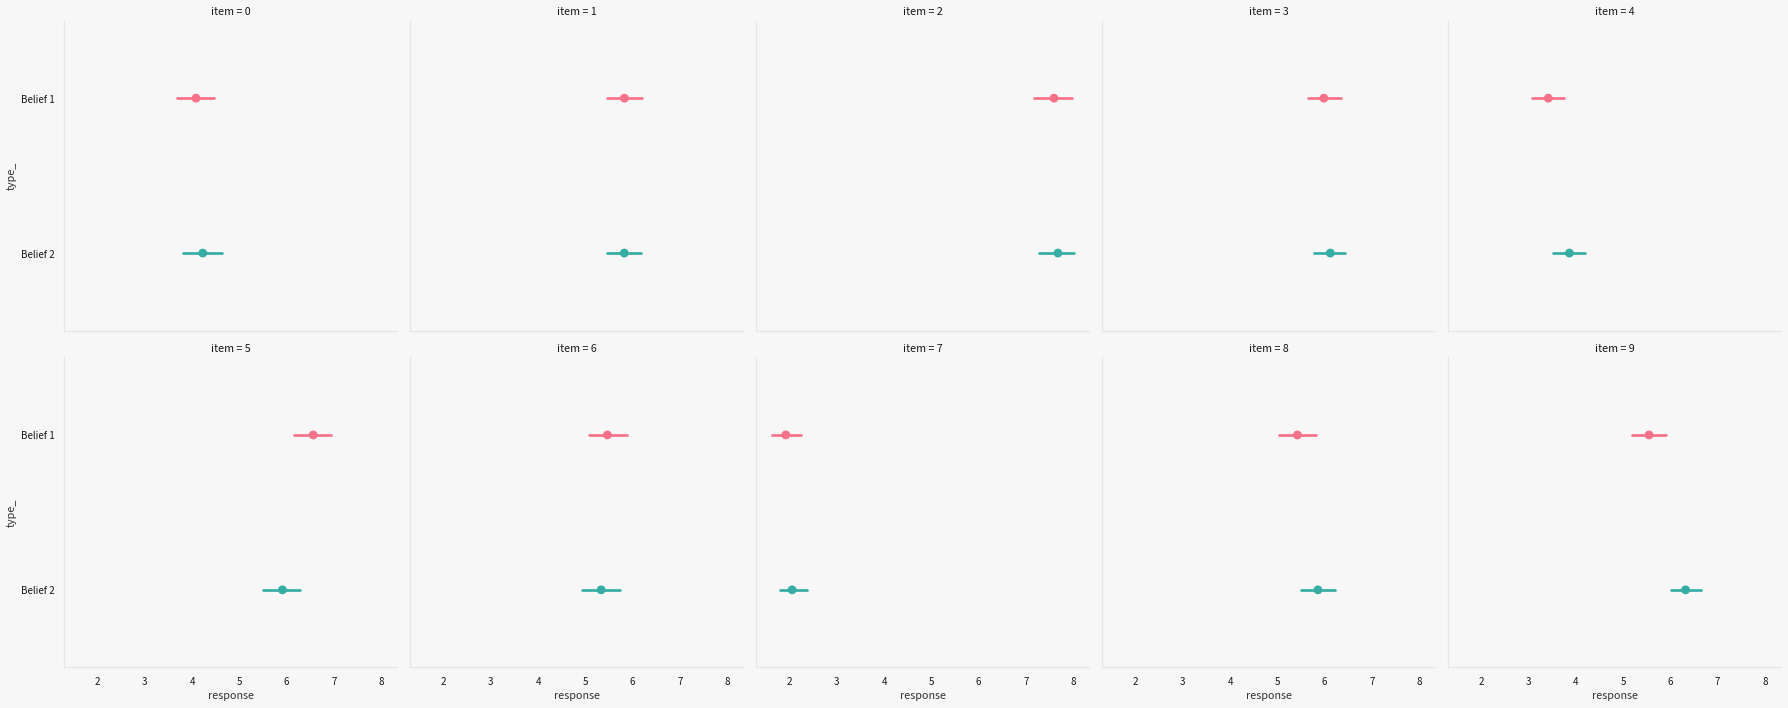

In [9]:
# There are a lot of ITEMS, so only show first 10
ITEMS = range(10)
TYPES = ('Belief 1', 'Belief 2')
sns.catplot(data=item_group.query('condition == @CONTROL and item in @ITEMS and type_ in @TYPES'), col='item', y='type_', 
            x='response', kind='point', palette='husl', ci=95, col_wrap=5);

This also looks very good. Just to hammer the point home, I'll include a paired scatterplot to compare individual people.

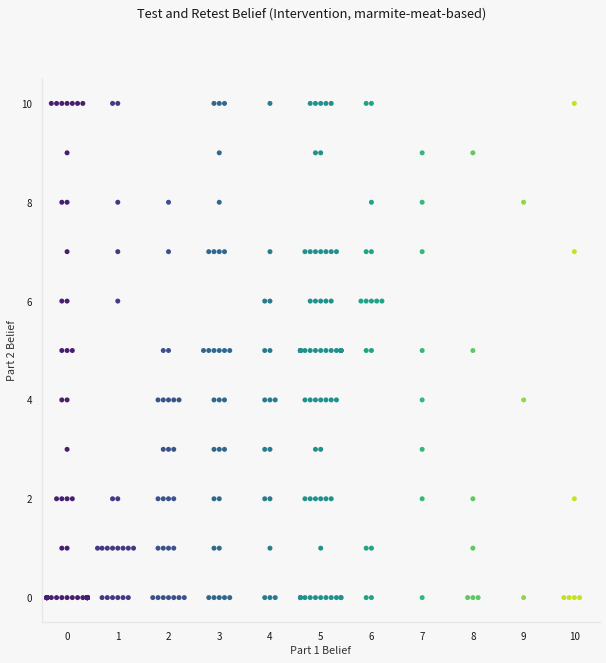

In [10]:
QUESTION = 34 # 1 = "women talk more", 34 = "marmite is meat-based"
col1 = data.query("Condition == @INTERVENTION")[part1_belief[QUESTION]]
col2 = data.query("Condition == @INTERVENTION")[part2_belief[QUESTION]]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.swarmplot(x=col1, y=col2, palette=palette, ax=ax)
ax.set_xlabel("Part 1 Belief")
ax.set_ylabel("Part 2 Belief")
fig.suptitle("Test and Retest Belief (Intervention, {})".format(questions[QUESTION]));

Besides the weird outliers (there seem to be a couple of people who responded more or less at random to every question, unfortunately), this seems pretty reasonable. It's a nice visual depiction of the reliability of the different items: you can try `QUESTION = 34` (the Marmite meat one) to see how this looks for an item with an illusory backfire.

# Results
This section moves on to testing the actual hypotheses.

### Backfire Effect Presence
First, did any items backfire as a whole? I interpret this as "were there any false items that had a part 2 belief significantly less than the part 1 belief in the intervention group?" (This conspicuously excludes facts, even if their belief change was the reverse of the expected direction. I'm not quite certain what's the best approach to dealing with those.)

I'll start with a visual. This shows the mean proportion of backfires (defined as a +2 or higher change in belief for the myths), It's sorted so you can see which items had, on average, more backfires.

What matters for our hypothesis is that no items had a backfire proportion over 50%.

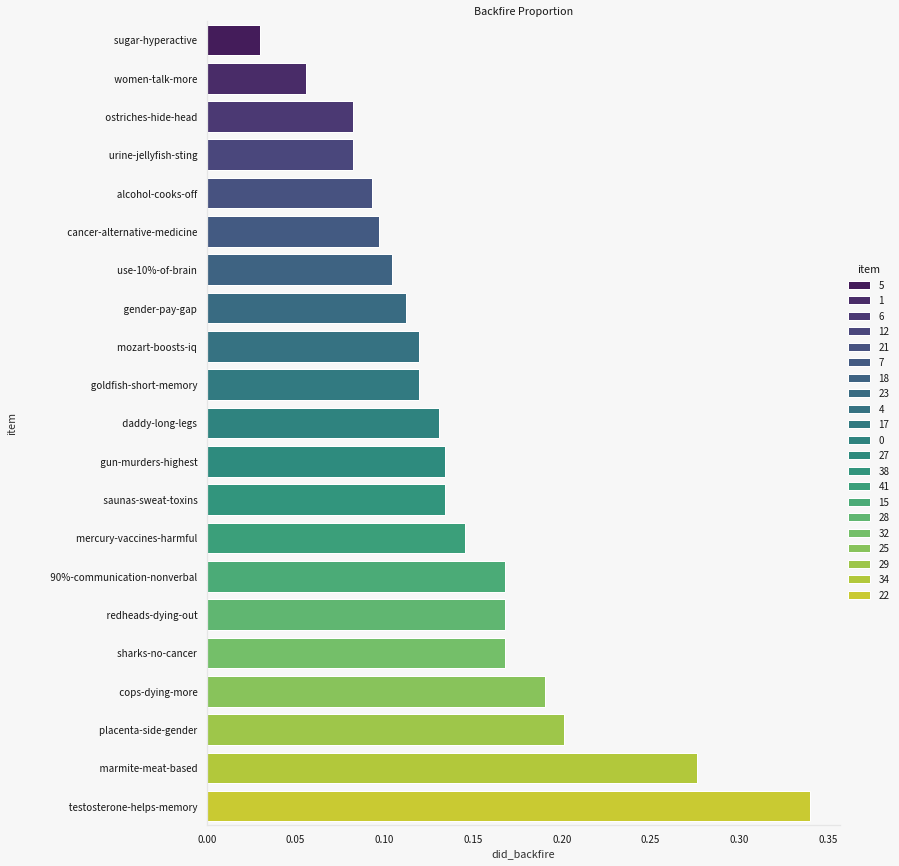

In [11]:
b1 = intr.query('type_ == "Belief 1"')
b1.index = range(len(b1.index))
b2 = intr.query('type_ == "Belief 2"')
b2.index = range(len(b2.index))
deltas = b2.copy()
deltas['response'] = deltas['response'] - b1['response']
deltas['did_backfire'] = deltas['response'] >= 2
myths = np.nonzero(~truth)[0]
myth_deltas = deltas.query('item in @myths')

backfire_props = myth_deltas.groupby('item').mean().sort_values('did_backfire')['did_backfire']
order = myth_deltas.groupby('item').mean().sort_values('did_backfire')['did_backfire'].index
grid = sns.catplot(data=myth_deltas, x='did_backfire', y='item', kind='bar', hue='item', dodge=False, orient='h', 
                   palette=palette, hue_order=order, order=order, height=12, aspect=0.8, ci=None)
labels = ["{:>40}".format(questions[i]) for i in order] 
grid.ax.set_yticklabels(labels=labels);
grid.ax.set_title("Backfire Proportion")
print()

We can more rigorously test by using a binomial proportion test, with the null hypothesis being that more than 50% of respondents backfire. (This is maybe not the perfect choice, but it's easy!)

In [12]:
for item in order:
    did_backfire = myth_deltas.query('item == @item')['did_backfire']
    p = scipy.stats.binom_test(did_backfire.sum(), len(did_backfire), p=0.5, alternative='greater')
    print("{:>40}: % = {:+06.1%}, p = {:.3f}".format(questions[item], did_backfire.mean(), p))

                       sugar-hyperactive: % = +03.0%, p = 1.000
                         women-talk-more: % = +05.6%, p = 1.000
                     ostriches-hide-head: % = +08.2%, p = 1.000
                   urine-jellyfish-sting: % = +08.2%, p = 1.000
                       alcohol-cooks-off: % = +09.3%, p = 1.000
             cancer-alternative-medicine: % = +09.7%, p = 1.000
                        use-10%-of-brain: % = +10.4%, p = 1.000
                          gender-pay-gap: % = +11.2%, p = 1.000
                        mozart-boosts-iq: % = +11.9%, p = 1.000
                   goldfish-short-memory: % = +11.9%, p = 1.000
                         daddy-long-legs: % = +13.1%, p = 1.000
                     gun-murders-highest: % = +13.4%, p = 1.000
                     saunas-sweat-toxins: % = +13.4%, p = 1.000
                mercury-vaccines-harmful: % = +14.6%, p = 1.000
             90%-communication-nonverbal: % = +16.8%, p = 1.000
                      redheads-dying-out

As we can see, there are no backfires that meet statistical significance for any reasonable value of $\alpha$. Even if you demote the threshold to 40% it's still not even close.

Text(0.5, 0.98, 'Belief Change After Correction Per Item')

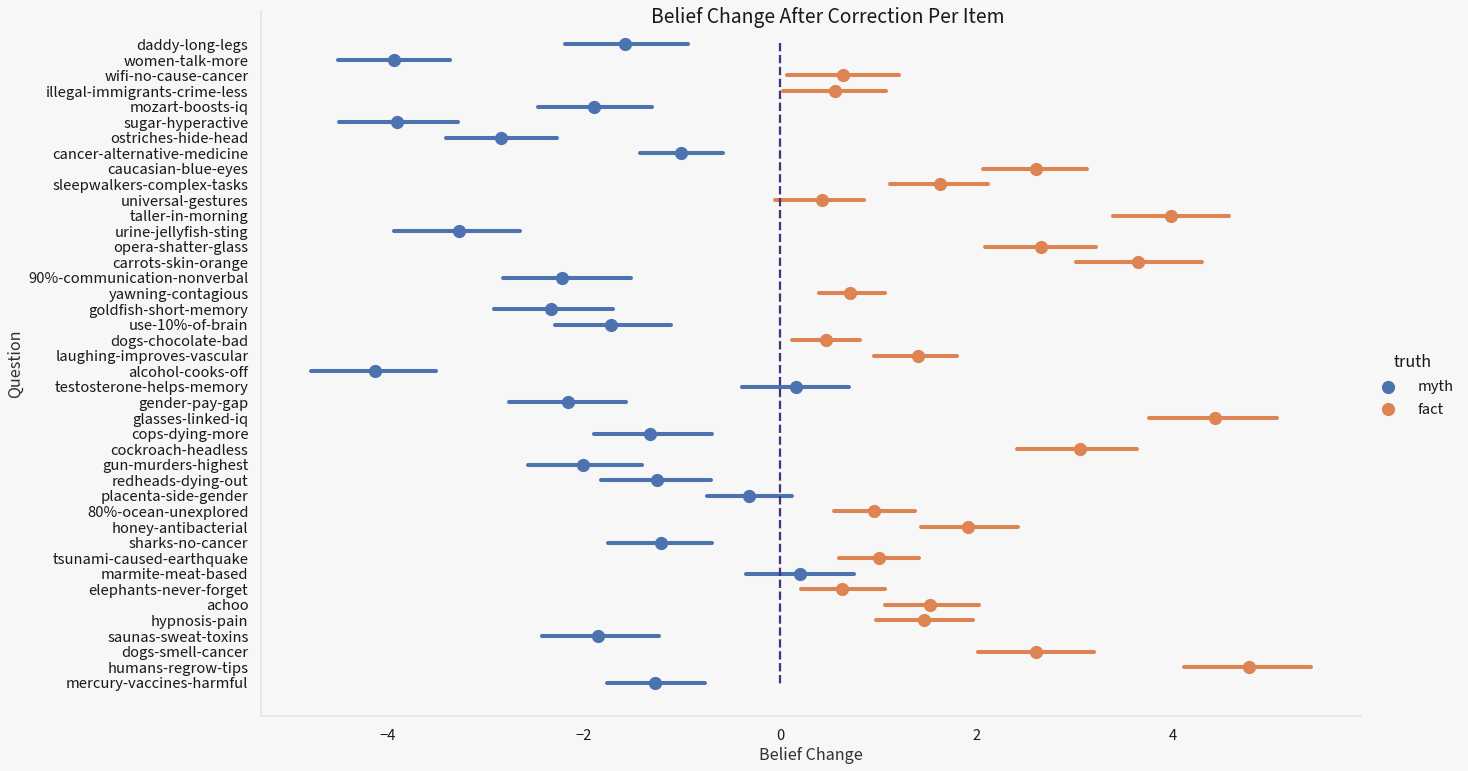

In [13]:
sns.set_context('talk')
order = deltas.groupby('item').mean().sort_values('response').index

deltas['truth'] = np.array(['fact', 'myth'])[deltas['item'].isin(myths).astype(int)]
g = sns.catplot(data=deltas, y='item', x='response', kind='point', orient='h', join=False, 
                aspect=1.5, height=11, hue='truth', palette='deep', ci=99)
g.ax.plot((0, 0), (-0.1, 41.1), '--')
g.ax.set_yticklabels(np.array(questions));
g.ax.set_xlabel("Belief Change")
g.ax.set_ylabel("Question")
g.fig.suptitle("Belief Change After Correction Per Item")

Text(0.5, 0.98, 'Belief Change After Correction Per Item')

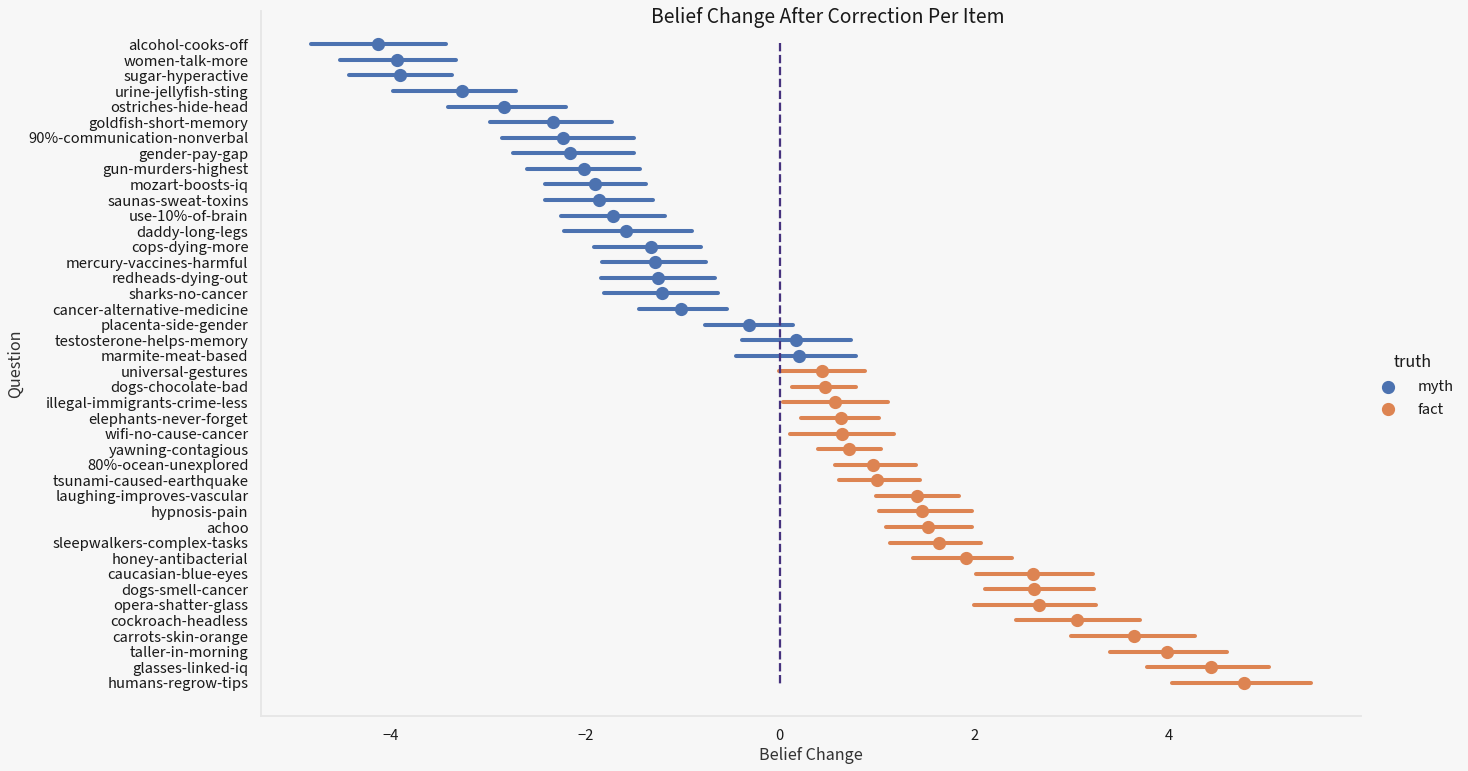

In [14]:
order = deltas.groupby('item').mean().sort_values('response').index

deltas['truth'] = np.array(['fact', 'myth'])[deltas['item'].isin(myths).astype(int)]
g = sns.catplot(data=deltas, y='item', x='response', kind='point', orient='h', join=False, 
                aspect=1.5, height=11, hue='truth', order=order, palette='deep', ci=99)
g.ax.plot((0, 0), (-0.1, 41.1), '--')
g.ax.set_yticklabels(np.array(questions)[order]);
g.ax.set_xlabel("Belief Change")
g.ax.set_ylabel("Question")
g.fig.suptitle("Belief Change After Correction Per Item")

### Reliability and Backfire

Next up: how do people's changes after correction relate to the item reliability? Specifically, I'll look at $R^2$ between test and retest in the control group versus the belief change as above. Keep in mind that, although mean change and $R^2$ are both measures of change in a paired dataset, they're used on different datasets in the graph: the $R^2$ is for the control, and the mean change is for the intervention.

In [15]:
# I'll be doing a lot of item-level regression plots, so I'm streamlining them here
def item_regplot(x, xlabel, y, ylabel, **kwargs):
    ax = sns.regplot(x, y, line_kws={'linestyle': ':'}, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{xlabel} vs. {ylabel}")
    m, b, r, p, std_err = scipy.stats.linregress(x, y)
    print("m = {:.3f}, b = {:.3f}, r = {:.3f}, r^2 = {:.3f}, p = {:.3f}, std_err = {:.3f}".format(
        m, b, r, r ** 2, p, std_err))
    return ax

m = -0.428, b = 0.303, r = -0.796, r^2 = 0.633, p = 0.000, std_err = 0.075


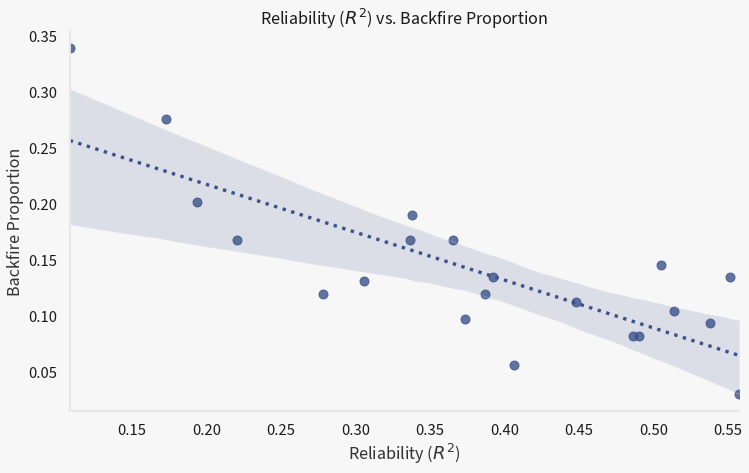

In [16]:
r_squared = []
order = myth_deltas.groupby('item').mean().sort_values('did_backfire')['did_backfire'].index
for item in order:
    subset = ctrl.query('item == @item')
    r_squared.append(scipy.stats.pearsonr(subset.query('type_ == "Belief 1"')['response'],
                                          subset.query('type_ == "Belief 2"')['response'])[0] ** 2)
    
item_regplot(r_squared, 'Reliability ($R^2$)', backfire_props, 'Backfire Proportion', color=c1)

This seems to confirm the hypothesis that reliability and backfire are inversely correlated. I'll now move on to examining the other items in the survey and how they correlate with the above.

### Familiarity 
How does familiarity with an item correlate with reliability and belief change? I'll look at mean familiarity across the entire dataset.

m = -0.025, b = 0.284, r = -0.849, r^2 = 0.721, p = 0.000, std_err = 0.004


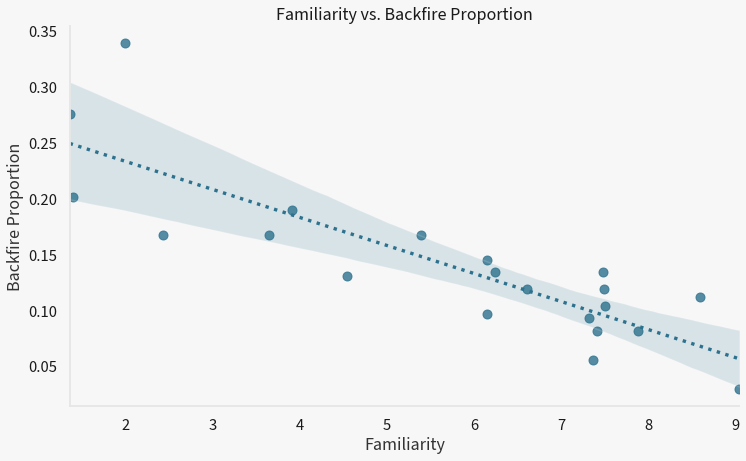

In [17]:
mean_fam = item_group.query('type_ == "Familiarity"').groupby('item').mean().loc[order, 'response']
item_regplot(mean_fam, 'Familiarity', backfire_props, 'Backfire Proportion', color=c2)

This is an even stronger relation than the last one. It's hard to tease out causation when you have lots of different correlations like this: is familiarity responsible for the variation in belief change (say, because corrections to more familiar items are more salient), or relability (from regression effects, perhaps), or both, or neither?

m = 0.045, b = 0.124, r = 0.816, r^2 = 0.666, p = 0.000, std_err = 0.007


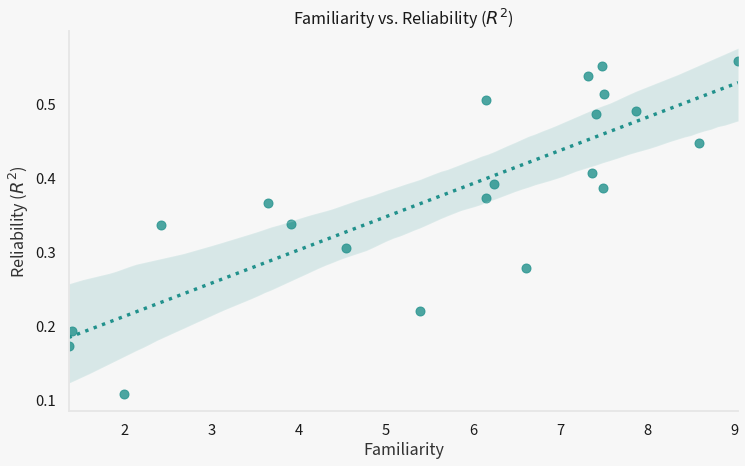

In [18]:
item_regplot(mean_fam, 'Familiarity', r_squared, 'Reliability ($R^2$)', color=c3)

As would be expected, familiarity and reliability corrrelate strongly as well.

### Importance
If a worldview backfire effect holds, then items ranked as important for the respondent or for society should have less belief change. Is this true?

m = -0.009, b = 0.181, r = -0.234, r^2 = 0.055, p = 0.308, std_err = 0.009


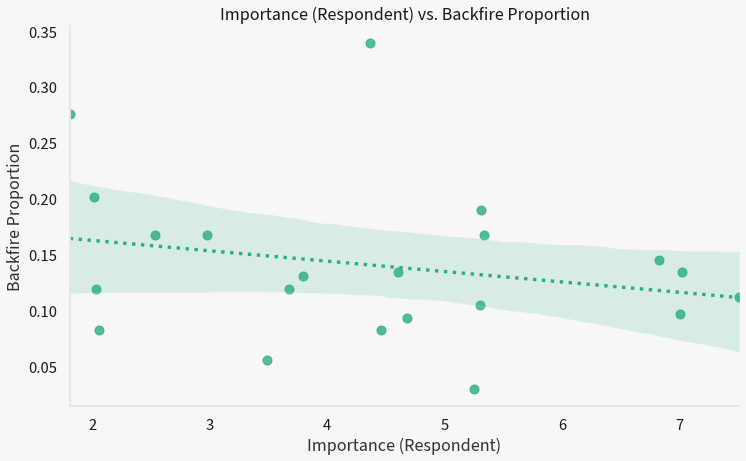

In [19]:
mean_imp_you = item_group.query('type_ == "Importance (You)"').groupby('item').mean().loc[order, 'response']
item_regplot(mean_imp_you, 'Importance (Respondent)', backfire_props, 'Backfire Proportion', color=c4)

There doesn't seem to be a strong effect here. If anything, the slope is negative, which contradicts the idea that more important items would backfire more.

m = 0.600, b = 3.080, r = 0.446, r^2 = 0.199, p = 0.043, std_err = 0.276


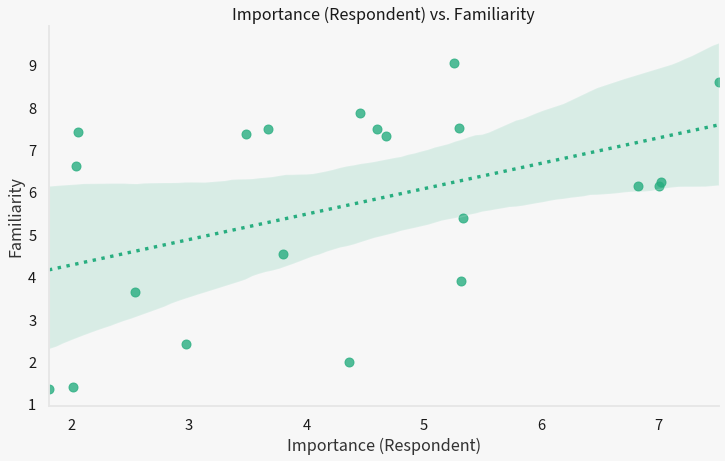

In [20]:
item_regplot(mean_imp_you, 'Importance (Respondent)', mean_fam, 'Familiarity', color=c4)

This is a shakier relationship than the above, but it's still significant at $\alpha = 0.05$. This one makes a lot of sense: things that aren't familiar to you are probably also not especially important to you.

One thing I found interesting about the survey was the choice to split importance into importance to the respondent and to society. I wondered how respondents would differentiate the two, so let's plot that relationship:

m = 1.119, b = 0.329, r = 0.980, r^2 = 0.961, p = 0.000, std_err = 0.052


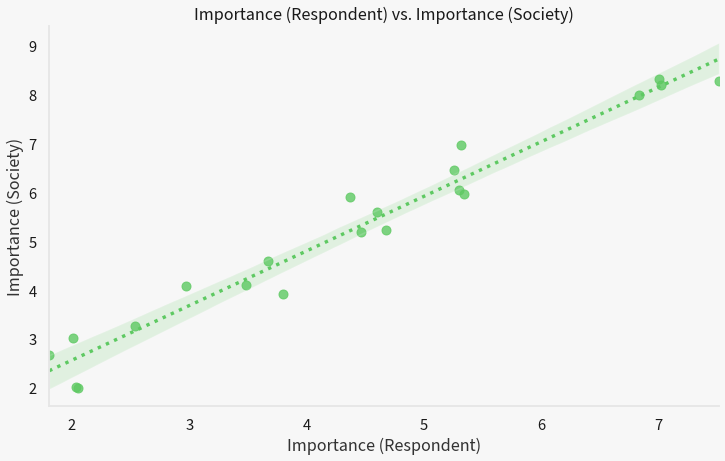

In [21]:
mean_imp_soc = item_group.query('type_ == "Importance (Society)"').groupby('item').mean().loc[order, 'response']
item_regplot(mean_imp_you, 'Importance (Respondent)', mean_imp_soc, 'Importance (Society)', color=c5)

Evidently most people seem to think things are generally important or not in a way that doesn't depend much on who's judging the importance. Given this, I'll stick to the importance to the respondent for the remaining analysis: I doubt there's much of a difference. We can also look at what items have the largest differences between the two to corroborate what these items mean:

In [22]:
print('{:>40} - {}'.format("Question", "Difference (Respondent - Society)"))
print('\n'.join("{:>40} - {:+.3f}".format(questions[i], (mean_imp_you - mean_imp_soc)[i]) 
                for i in np.abs((mean_imp_you - mean_imp_soc)).sort_values(ascending=False).index))

                                Question - Difference (Respondent - Society)
                         cops-dying-more - -1.662
               testosterone-helps-memory - -1.549
             cancer-alternative-medicine - -1.329
                       sugar-hyperactive - -1.216
                     gun-murders-highest - -1.190
                mercury-vaccines-harmful - -1.164
                        sharks-no-cancer - -1.105
                    placenta-side-gender - -1.008
                     saunas-sweat-toxins - -1.000
                        mozart-boosts-iq - -0.927
                      marmite-meat-based - -0.859
                          gender-pay-gap - -0.767
                        use-10%-of-brain - -0.756
                   urine-jellyfish-sting - -0.729
                      redheads-dying-out - -0.724
             90%-communication-nonverbal - -0.639
                         women-talk-more - -0.617
                       alcohol-cooks-off - -0.553
                       

This makes sense: the highest differences are politics and medicine. It's interesting that, although the dataset are very highly correlated, people do seem to rate things as more important for other people than for themselves somewhat consistently: only two items have a higher mean score for importance to the respondent.

m = 0.028, b = 0.256, r = 0.382, r^2 = 0.146, p = 0.088, std_err = 0.016


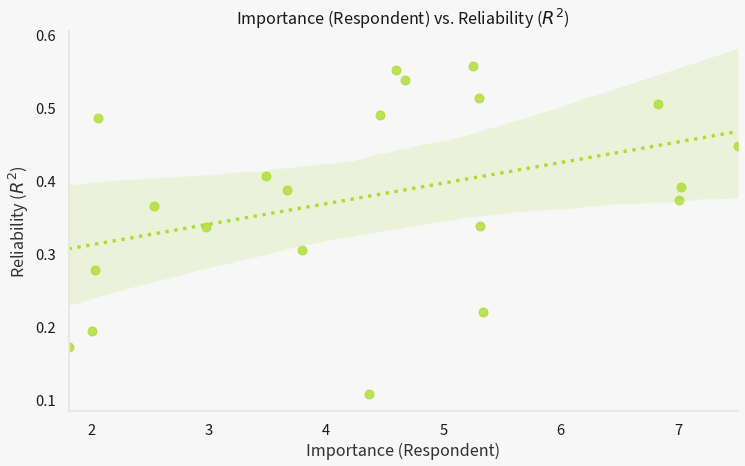

In [23]:
item_regplot(mean_imp_you, 'Importance (Respondent)', r_squared, 'Reliability ($R^2$)', color=c6)

This isn't quite significant, which is interesting: for test-retest consistency, it's more important to have heard something before than to necessarily think it's important to you or the world.

# Paper Figures/Stats

This will be recreating the figures from the paper and generating the stats necessary.

## Figure 1
Comparing pre- and post-correction scores, highlighting the backfire zone.

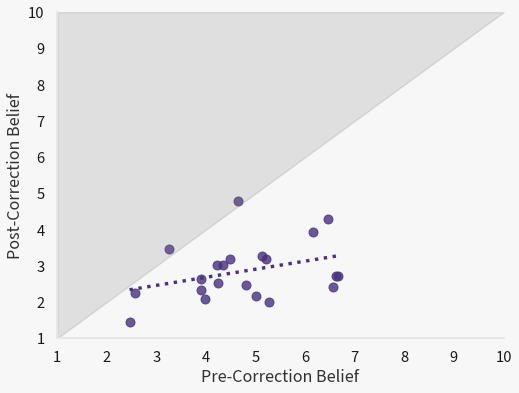

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.regplot(b1.groupby('item').mean()['response'][order], b2.groupby('item').mean()['response'][order], ci=None,
            line_kws={'linestyle': ':'}, ax=ax)

ax.set_xlabel('Pre-Correction Belief')
ax.set_ylabel('Post-Correction Belief')
ax.set_xlim(1, 10)
ax.set_ylim(1, 10)
ax.fill_between(np.linspace(1, 10, 100), np.linspace(1, 10, 100), np.ones(100) * 10, alpha=0.2, color='grey')

## Figure 2

Showing the backfire percentage by item number.

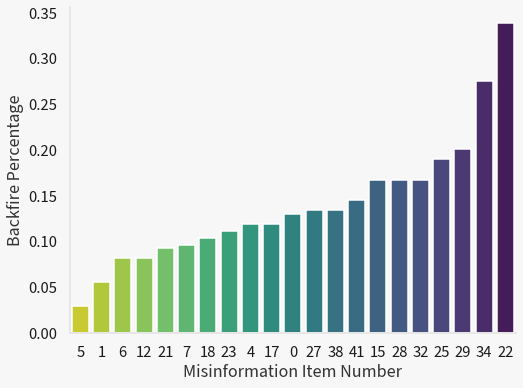

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(data=myth_deltas, x='item', y='did_backfire', ax=ax,
            hue_order=order, order=order, ci=None, palette=palette + '_r')

ax.set_xlabel('Misinformation Item Number')
ax.set_ylabel('Backfire Percentage');

## Figure 3

Showing correlations with backfire percentage and the other item-level data.

m = -0.009, b = 0.181, r = -0.234, r^2 = 0.055, p = 0.308, std_err = 0.009
m = -0.004, b = 0.162, r = -0.118, r^2 = 0.014, p = 0.609, std_err = 0.008
m = -0.025, b = 0.284, r = -0.849, r^2 = 0.721, p = 0.000, std_err = 0.004


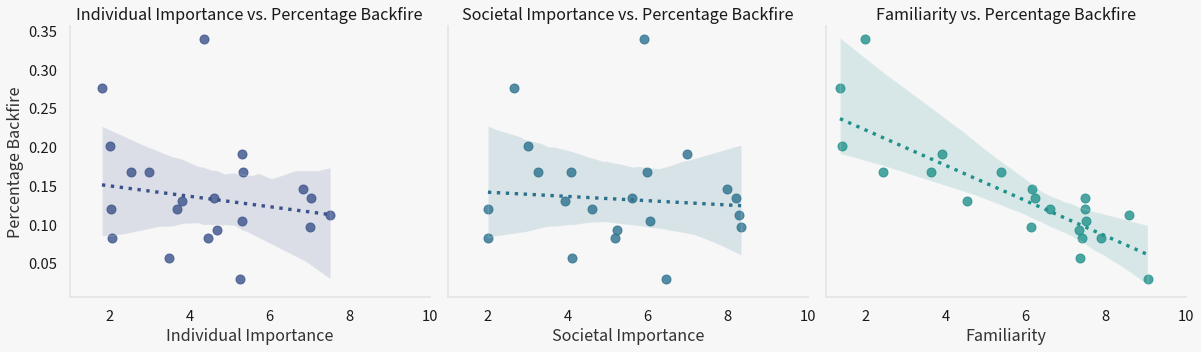

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharey=True, gridspec_kw={'wspace': 0.05})
item_regplot(mean_imp_you, 'Individual Importance', backfire_props, 'Percentage Backfire', color=c1, 
             ci=99, ax=ax1, robust=True)
item_regplot(mean_imp_soc, 'Societal Importance', backfire_props, '', color=c2, ci=99, ax=ax2, robust=True)
item_regplot(mean_fam, 'Familiarity', backfire_props, '', color=c3, ci=99, ax=ax3, robust=True)


for ax in (ax1, ax2, ax3):
    ax.set_xlim(1, 10)
    
ax2.set_title("Societal Importance vs. Percentage Backfire")
ax3.set_title("Familiarity vs. Percentage Backfire");

m = -0.009, b = 0.181, r = -0.234, r^2 = 0.055, p = 0.308, std_err = 0.009
m = -0.004, b = 0.162, r = -0.118, r^2 = 0.014, p = 0.609, std_err = 0.008
m = -0.025, b = 0.284, r = -0.849, r^2 = 0.721, p = 0.000, std_err = 0.004


Text(0.5, 1.0, 'Familiarity vs. Percentage Backfire')

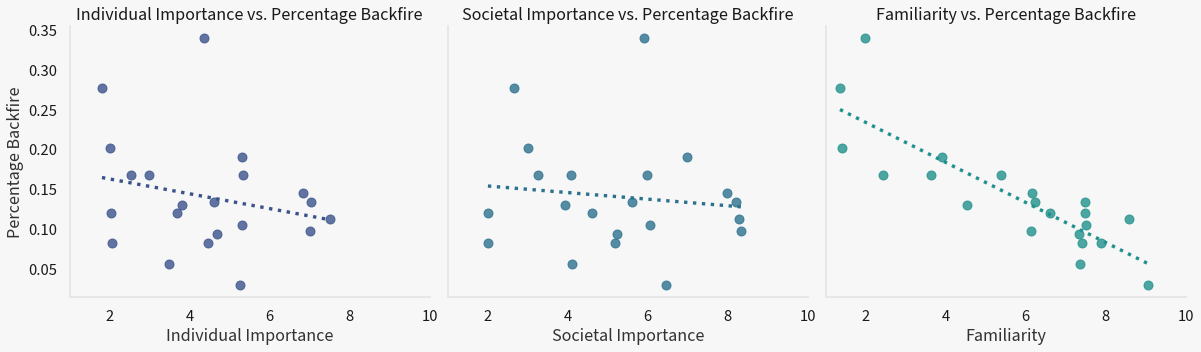

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharey=True, gridspec_kw={'wspace': 0.05})
item_regplot(mean_imp_you, 'Individual Importance', backfire_props, 'Percentage Backfire', color=c1, 
             ci=None, ax=ax1)
item_regplot(mean_imp_soc, 'Societal Importance', backfire_props, '', color=c2, ci=None, ax=ax2)
item_regplot(mean_fam, 'Familiarity', backfire_props, '', color=c3, ci=None, ax=ax3)


for ax in (ax1, ax2, ax3):
    ax.set_xlim(1, 10)
    
ax2.set_title("Societal Importance vs. Percentage Backfire")
ax3.set_title("Familiarity vs. Percentage Backfire")

m = -0.505, b = 0.446, r = -0.830, r^2 = 0.690, p = 0.000, std_err = 0.078


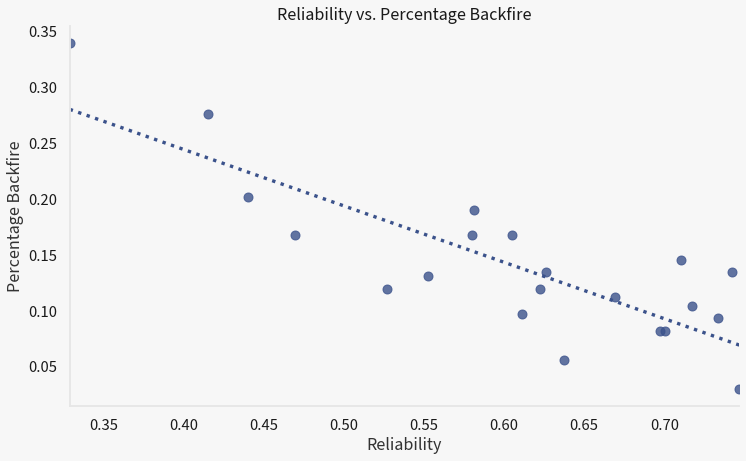

In [28]:
ax = item_regplot(np.sqrt(r_squared), 'Reliability', backfire_props, 'Percentage Backfire', color=c1, ci=None)

## Illusory Truth in Control
Here we examine the illusory truth effect as it applies to the control group. As I understand it, this essentially says that the control group's round 2 beliefs should be higher on average for each item.

In [29]:
ctrl.head()

,condition,What is your Prolific ID?,question,response,item,type_
532,2,5e31f103a976891de17f30d2,The daddy long legs spider is extremely venomo...,0,0,Belief 1
533,2,5da7825f634607001172ca6a,The daddy long legs spider is extremely venomo...,4,0,Belief 1
534,2,5da8893e7a7b6a0011965f84,The daddy long legs spider is extremely venomo...,7,0,Belief 1
535,2,5e5d730f62ff4608804ad7a5,The daddy long legs spider is extremely venomo...,4,0,Belief 1
537,2,5ec74032fa02b71929197051,The daddy long legs spider is extremely venomo...,2,0,Belief 1


In [30]:
ctrl_pre_post = pd.merge(ctrl.query('type_ == "Belief 1"'), ctrl.query('type_ == "Belief 2"'), on=[ID_COL, 'item'])[[ID_COL, 'item', 'response_x', 'response_y']]
ctrl_pre_post = ctrl_pre_post.rename(columns={'response_x': '1', 'response_y': '2'}).melt(id_vars=[ID_COL, 'item'], value_name='belief', var_name='part')

This is unpaired, but useful for a broad-strokes look: we can see that this effect is mostly not significant but present. Note the questions where the effect does occur: it tends to be on items with less familiarity, which makes sense, but also on items with lower starting beliefs, which suggests a regression effect.

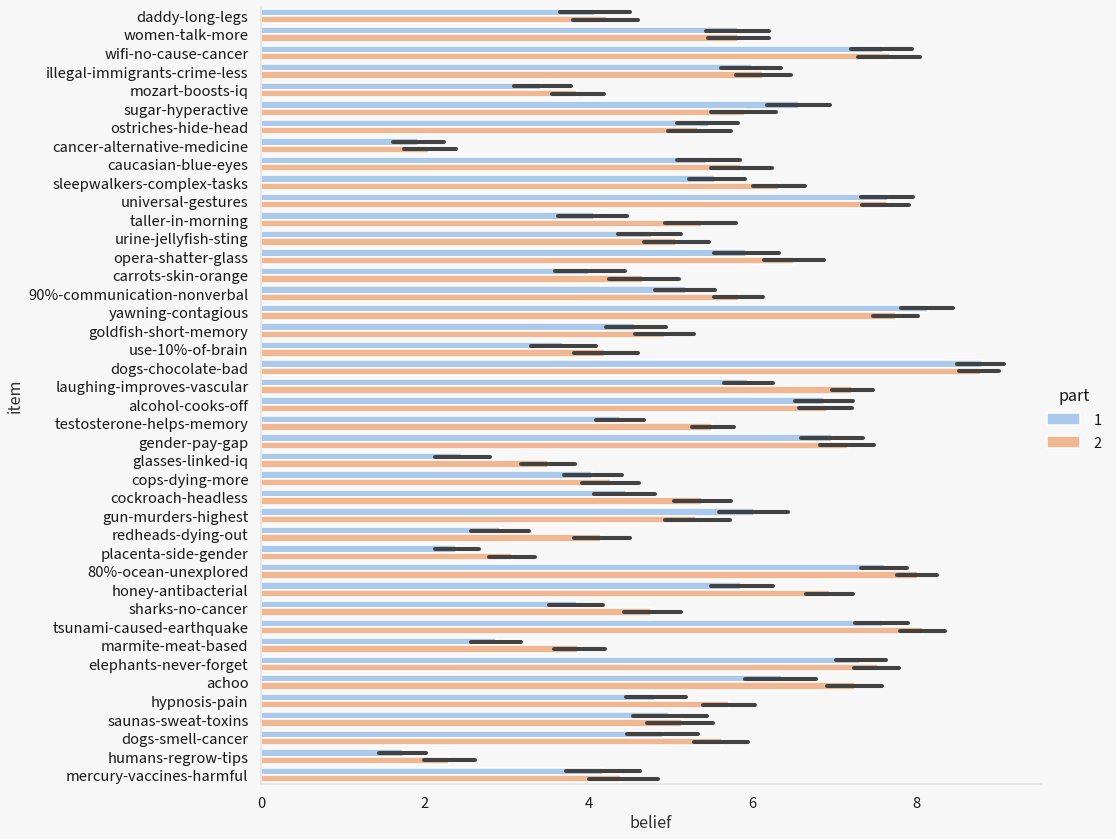

In [31]:
g = sns.catplot(data=ctrl_pre_post, y='item', x='belief', hue='part', kind='bar', aspect=1, height=12, dodge=0.3, orient='h', palette='pastel', ci=95)
g.ax.set_yticklabels(questions);

Now we use paired deltas. This has a pretty wide variation that's hard to attribute to any one specific thing, but as we can see (the plot of familiarity and delta use the same ordering, so the weak line in the second plot suggests a correlation) familiarity is a big part of it.

In [32]:
ctrl_deltas = pd.merge(ctrl.query('type_ == "Belief 1"'), ctrl.query('type_ == "Belief 2"'), on=[ID_COL, 'item'])[[ID_COL, 'item', 'response_x', 'response_y']]
ctrl_deltas.rename(columns={'response_x': 'b1', 'response_y': 'b2'}, inplace=True)
ctrl_deltas['delta'] = ctrl_deltas['b2'] - ctrl_deltas['b1']

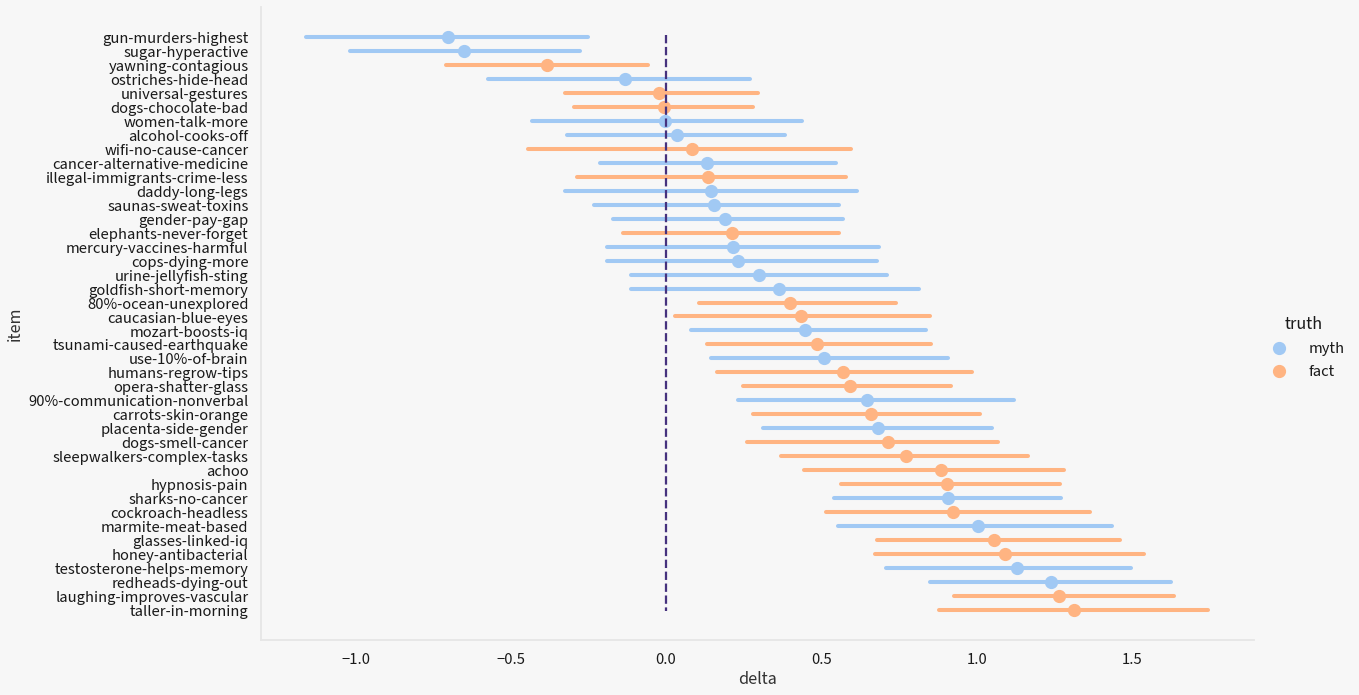

In [33]:
order = ctrl_deltas.groupby('item').mean().sort_values('delta').index

ctrl_deltas['truth'] = np.array(['fact', 'myth'])[ctrl_deltas['item'].isin(myths).astype(int)]


g = sns.catplot(data=ctrl_deltas, y='item', x='delta', kind='point', orient='h', join=False, aspect=1.5, height=10, hue='truth',
               order=order, palette='pastel', ci=99)
g.ax.plot((0, 0), (-0.1, 41.1), '--')
g.ax.set_yticklabels(np.array(questions)[order]);

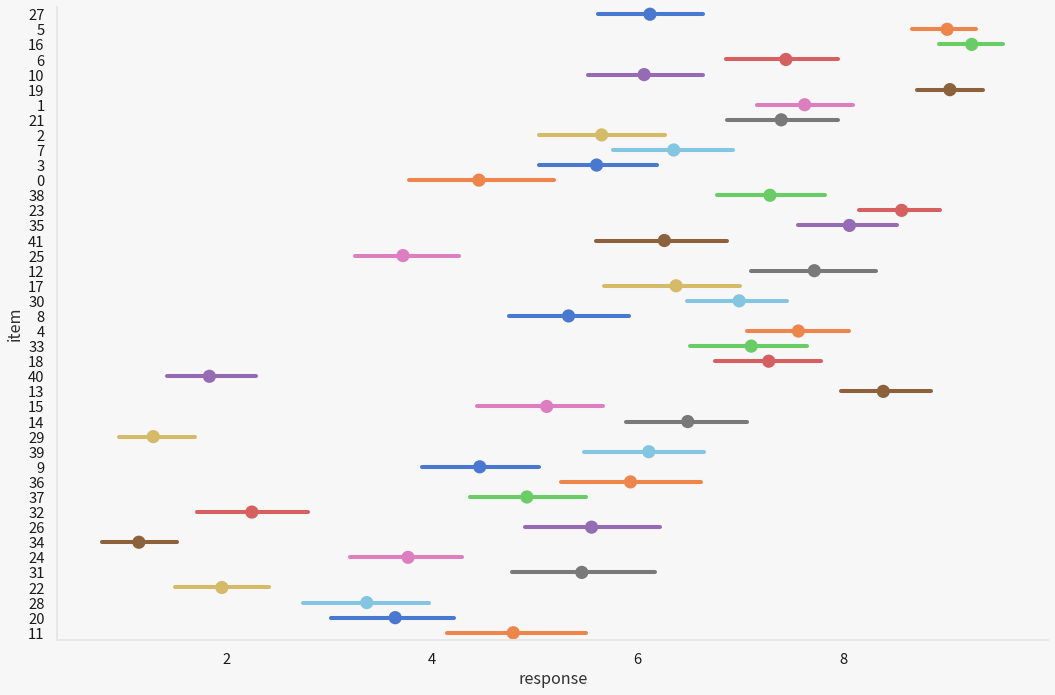

In [34]:
ctrl_fam = ctrl.query('type_ == "Familiarity"')
sns.catplot(data=ctrl_fam, y='item', x='response', kind='point', orient='h', join=False, aspect=1.5, height=10, ci=99, order=order,
            palette='muted')

In [35]:
ctrl_items = ctrl.drop(columns=['condition', 'question']).set_index(['item', ID_COL, 'type_']).unstack(-1)
ctrl_items.columns = list(ctrl_items.columns.droplevel(0))
ctrl_items['delta'] = ctrl_items['Belief 2'] - ctrl_items['Belief 1']
ctrl_items.head()

Belief 1  Belief 2  Familiarity  \
item What is your Prolific ID?                                    
0    54847013fdf99b0379939c8a          8         7           10   
     54af2a48fdf99b09c01b3801          2         7            7   
     55534b84fdf99b6bd29dd0aa          7         2            9   
     559d9916fdf99b1e2b2dc6b8          5         5            0   
     55a432fcfdf99b02ff6caf92          1         2            0   

                                Importance (Society)  Importance (You)  delta  
item What is your Prolific ID?                                                 
0    54847013fdf99b0379939c8a                      3                 2     -1  
     54af2a48fdf99b09c01b3801                      4                 2      5  
     55534b84fdf99b6bd29dd0aa                      0                 0     -5  
     559d9916fdf99b1e2b2dc6b8                      1                 1      0  
     55a432fcfdf99b02ff6caf92                      1                 1      1

In [36]:
ctrl_items.groupby(['Familiarity', 'delta']).size().unstack()

delta,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,...,1,2,3,4,5,6,7,8,9,10
Familiarity,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,2.0,4.0,16.0,36.0,26.0,46.0,96.0,136.0,...,337.0,265.0,227.0,127.0,174.0,69.0,44.0,24.0,18.0,35.0
1,NaN,NaN,2.0,NaN,1.0,6.0,8.0,11.0,33.0,58.0,...,87.0,65.0,47.0,30.0,25.0,15.0,11.0,6.0,7.0,3.0
2,2.0,NaN,NaN,1.0,2.0,7.0,8.0,13.0,37.0,57.0,...,83.0,51.0,49.0,24.0,14.0,5.0,5.0,5.0,2.0,5.0
3,NaN,NaN,2.0,NaN,2.0,4.0,4.0,11.0,29.0,39.0,...,67.0,40.0,29.0,27.0,16.0,9.0,2.0,1.0,NaN,2.0
4,NaN,NaN,1.0,1.0,3.0,9.0,14.0,9.0,22.0,27.0,...,60.0,40.0,31.0,15.0,8.0,8.0,1.0,2.0,1.0,2.0
5,NaN,NaN,2.0,3.0,6.0,19.0,15.0,14.0,40.0,54.0,...,81.0,71.0,40.0,22.0,32.0,11.0,5.0,4.0,2.0,2.0
6,NaN,1.0,3.0,1.0,7.0,10.0,15.0,17.0,25.0,51.0,...,89.0,51.0,38.0,20.0,8.0,5.0,3.0,2.0,1.0,2.0
7,3.0,NaN,3.0,4.0,4.0,11.0,11.0,19.0,38.0,97.0,...,116.0,71.0,62.0,17.0,17.0,5.0,4.0,3.0,2.0,1.0
8,1.0,NaN,4.0,3.0,6.0,13.0,19.0,36.0,58.0,123.0,...,140.0,88.0,46.0,22.0,12.0,5.0,6.0,1.0,3.0,2.0


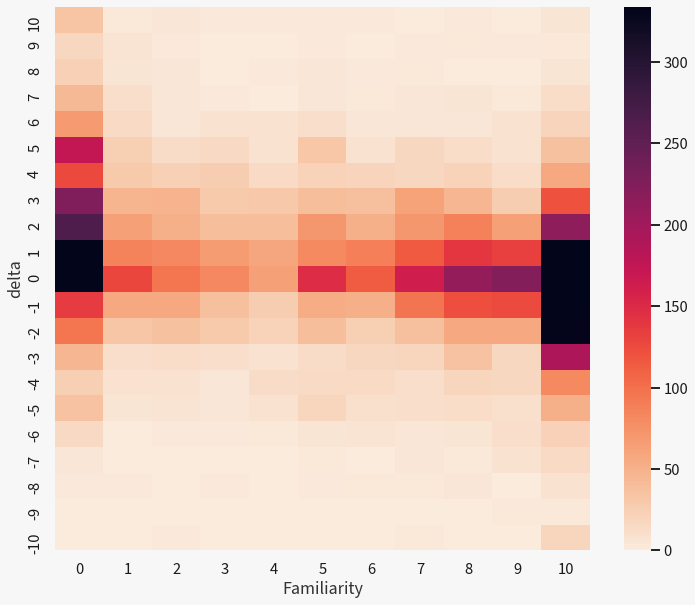

In [37]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(ctrl_items.groupby(['delta', 'Familiarity']).size().unstack(-1).fillna(0), cmap='rocket_r', robust=True, ax=ax)
ax.invert_yaxis()

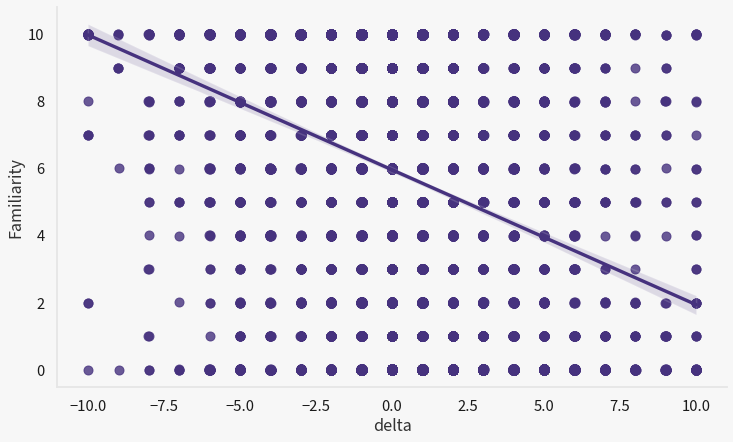

In [38]:
sns.regplot(data=ctrl_items, x='delta', y='Familiarity', x_jitter=0.01, y_jitter=0.01)

We can also use proportions of anti-backfires: how many people for each item reported a delta of at least 2:

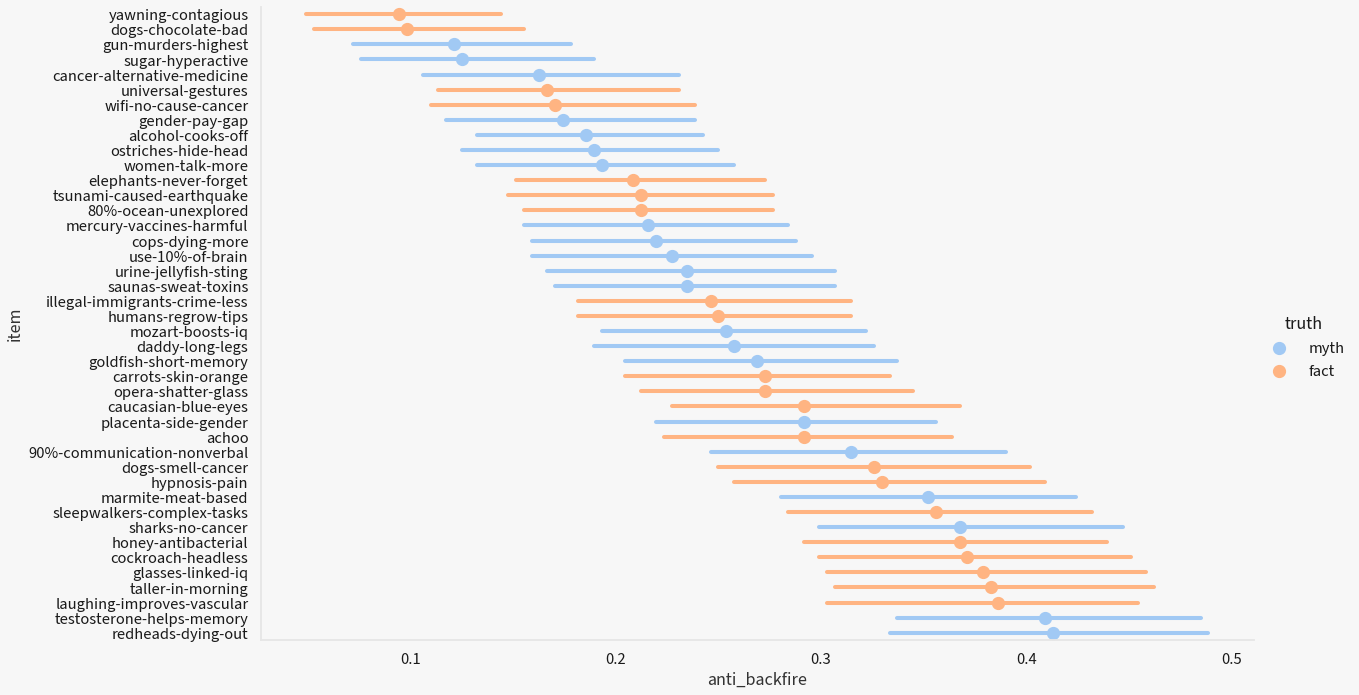

In [39]:
ctrl_deltas["anti_backfire"] = ctrl_deltas["delta"] >= 2
prop_anti_backfire = ctrl_deltas.groupby("item").mean()[["anti_backfire"]].sort_values('anti_backfire')
order = prop_anti_backfire.index

g = sns.catplot(data=ctrl_deltas, y='item', x="anti_backfire", kind='point', orient='h', join=False, aspect=1.5, height=10, hue='truth',
               order=order, palette='pastel', ci=99)
g.ax.set_yticklabels(np.array(questions)[order]);

## Formal Stats
Replication of the formal statistics used in the paper

### Core Backfire Effects: Pre-Post Intervention One-Way ANOVA


# Paper Summary Statistics
These are the parenthetical summary statistics used in the manuscript, generated here directly from the data.

## Demographics

In [40]:
raw_ages = part1['What is your age?']
genders = part1['Are you male or female?']

In [41]:
# a problematic age that is being omitted
print(raw_ages[437])
# someone put 282, I doubt that so it's being removed
print(raw_ages[raw_ages == 282])
# someone put 4, also doubt that so it's being removed
print(raw_ages[raw_ages == 4])
ages = pd.to_numeric(raw_ages.drop([69, 162, 437]))

R5
69    282
Name: What is your age?, dtype: object
162    4
Name: What is your age?, dtype: object


In [42]:
print("Ages range between {} and {} (M = {:.2f}, SD = {:.2f})".format(
    ages.min(), ages.max(), ages.mean(), ages.std()))

Ages range between 18 and 74 (M = 30.94, SD = 11.03)


In [43]:
print("There were {} people assigned to the correction condition, and {} to the control condition".format(
    len(_part2_intr.index) + len(_unmatched_part1.query('Condition == @INTERVENTION')),
    len(_part2_ctrl.index) + len(_unmatched_part1.query('Condition == @CONTROL').index),))

There were 297 people assigned to the correction condition, and 303 to the control condition


In [44]:
combo_part1 = pd.concat([part1, _unmatched_part1])
x = combo_part1['Condition'] == 1
y = combo_part1['Are you male or female?'] == 'Female'
# same results for Spearman's
print("Correlation between condition and gender: r = {:.2f}, p = {:.4f} (Pearson's)".format(
*scipy.stats.pearsonr(x, y)))

Correlation between condition and gender: r = -0.05, p = 0.2163 (Pearson's)


In [45]:
combo_ages = combo_part1['What is your age?'].drop([69, 162, 437])
print("Correlation between condition and age: r = {:.2f}, p = {:.4f} (Pearson's)".format(
*scipy.stats.pointbiserialr(x.drop([69, 162, 437]), combo_ages)))

Correlation between condition and age: r = -0.05, p = 0.2191 (Pearson's)


In [46]:
raw_ed_levels = combo_part1['What is the highest level of education you have completed?']
levels = ['Did not graduate from high school', 'High school graduate', 
          'Some college, but no degree', '2-year college degree', 
          '4-year college degree', 'Postgraduate degree (MA, MBA, MD, JD, PhD, etc.)']
ed_levels = [levels.index(i) for i in raw_ed_levels]

contingency_table = [[0 for _ in range(len(levels))] for _ in range(2)]
for condition, ed_level in zip(x, ed_levels):
    contingency_table[condition][ed_level] += 1
    
contingency_table = np.array(contingency_table)
    
print(contingency_table)
print("Correlation between condition and education: χ² = {:.2f}, p = {:.4f} (Chi-squared)".format(
*scipy.stats.chi2_contingency(contingency_table)))

# note that there are observed frequencies smaller than 5, which is usually bad
# excluding the "did not graduate high school category" to remove this issue, we get:

print("Correlation between condition and education, excluding obs < 5: χ² = {:.2f}, p = {:.4f} (Chi-squared)".format(
*scipy.stats.chi2_contingency(contingency_table[:, 1:])))

[[  2  49  66  39 123  55]
 [  0  46  69  31 148  40]]
Correlation between condition and education: χ² = 7.75, p = 0.1705 (Chi-squared)
Correlation between condition and education, excluding obs < 5: χ² = 5.74, p = 0.2191 (Chi-squared)


In [47]:
part1["Generally speaking, do you consider yourself to be a..."]

0         Democrat
1      Independent
2         Democrat
3         Democrat
4      Other Party
          ...     
595     Republican
596    Independent
597     Republican
598       Democrat
599    Independent
Name: Generally speaking, do you consider yourself to be a..., Length: 600, dtype: object

In [48]:
part1["Do you think of yourself as closer to the Republican Party or closer to the Democratic Party?"]

0                                 NaN
1                             Neither
2                                 NaN
3                                 NaN
4                             Neither
                    ...              
595                               NaN
596    Closer to the Democratic Party
597                               NaN
598                               NaN
599    Closer to the Democratic Party
Name: Do you think of yourself as closer to the Republican Party or closer to the Democratic Party?, Length: 600, dtype: object